In [0]:
# install library and download video for processing
!pip install sk-video>=1.1.8
import os
if not os.path.exists('road.mp4'):
    !wget https://learnml.s3.eu-north-1.amazonaws.com/road.mp4

# Tutorial: Making Road Traffic Counting App based on Computer Vision and OpenCV

<img src="https://miro.medium.com/max/1280/1*kFbuhpNtiUFUU0nL2n5NLA.png" />

Today we will learn how to count road traffic based on computer vision and without heavy deep learning algorithms.

For this tutorial, we will use only Python and OpenCV with the pretty simple idea of motion detection with help of background subtraction algorithm.


**Here is our plan:**
1. Understand the main idea of background subtraction algorithms that used for foreground detection.
2. OpenCV image filters.
3. Object detection by contours.
4. Building processing pipeline for further data manipulation.


In [0]:
# import needed modules

import os
import csv
import numpy as np
import logging
import logging.handlers
import math
import sys
import random
import numpy as np
import skvideo.io
import cv2
import matplotlib.pyplot as plt

from IPython.display import HTML
from base64 import b64encode

# without this some strange errors happen
cv2.ocl.setUseOpenCL(False)
random.seed(123)

# setup logging
def init_logging(level=logging.INFO):
    main_logger = logging.getLogger()
    for hnd in main_logger.handlers:
        main_logger.removeHandler(hnd)

    formatter = logging.Formatter(
        fmt='%(asctime)s.%(msecs)03d %(levelname)-8s [%(name)s] %(message)s', datefmt='%Y-%m-%d %H:%M:%S')

    handler_stream = logging.StreamHandler(sys.stdout)
    handler_stream.setFormatter(formatter)
    main_logger.addHandler(handler_stream)
    main_logger.setLevel(level)

    return main_logger

## Background subtraction algorithms


<img src="https://miro.medium.com/max/473/0*iNYtQubKAtK0OGG5.png" />

There are many different algorithms for background subtraction, but the main idea of them is very simple.

Let’s assume that you have a video of your room, and on some of the frames of this video there is no humans & pets, so basically it’s static, let’s call it background_layer. So to get objects that are moving on the video we just need to:

`foreground_objects = current_frame - background_layer`

But in some cases, we cant get static frame because lighting can change, or some objects will be moved by someone, or always exist movement, etc. In such cases we are saving some number of frames and trying to figure out which of the pixels are the same for most of them, then this pixels becoming part of background_layer. Difference generally in how we get this background_layer and additional filtering that we use to make selection more accurate.

In this lesson, we will use MOG algorithm for background subtraction and after processing, it looks like this:

<img src="https://miro.medium.com/max/2560/1*UctRAiOt_tyXOJd4aX1rZg.png" />

Training BG Subtractor...


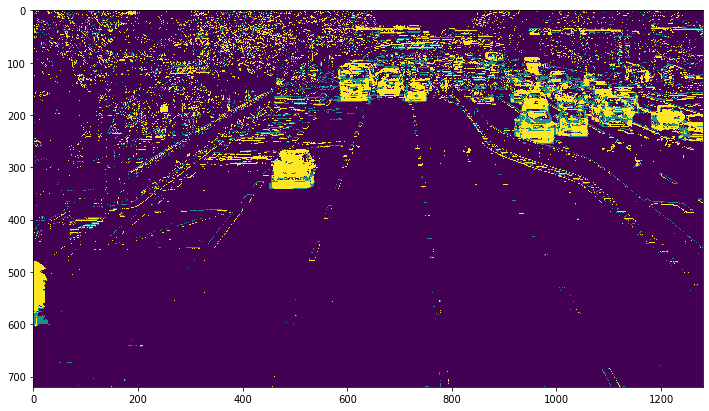

In [3]:
def train_bg_subtractor(inst, cap, num=500):
    '''
        BG substractor need process some amount of frames to start giving result
    '''
    print ('Training BG Subtractor...')
    i = 0
    for frame in cap:
        inst.apply(frame, None, 0.001)
        i += 1
        if i >= num:
            return cap

VIDEO_SOURCE = "2.1M Full HD 1080P CCTV Footage.mp4"

bg_subtractor = cv2.createBackgroundSubtractorMOG2(
        history=500, detectShadows=True)

# Set up image source
cap = skvideo.io.vreader(VIDEO_SOURCE)

# skipping 500 frames to train bg subtractor
train_bg_subtractor(bg_subtractor, cap, num=500)

frame = next(cap)
fg_mask = bg_subtractor.apply(frame, None, 0.001)

plt.figure(figsize=(12,12))
plt.imshow(fg_mask)
plt.show()

As you can see there is some noise on the foreground mask which we will try to remove with some standard filtering technic.

## Filtering

For our case we will need this filters: [Threshold](http://docs.opencv.org/3.1.0/d7/d4d/tutorial_py_thresholding.html), [Erode, Dilate, Opening, Closing](http://docs.opencv.org/3.1.0/d9/d61/tutorial_py_morphological_ops.html). Please go by links and read about each of them and look how they work (to not make copy/paste)

So now we will use them to remove some noise on foreground mask.
First, we will use Closing to remove gaps in areas, then Opening to remove 1–2 px points, and after that dilation to make object bolder.


Training BG Subtractor...


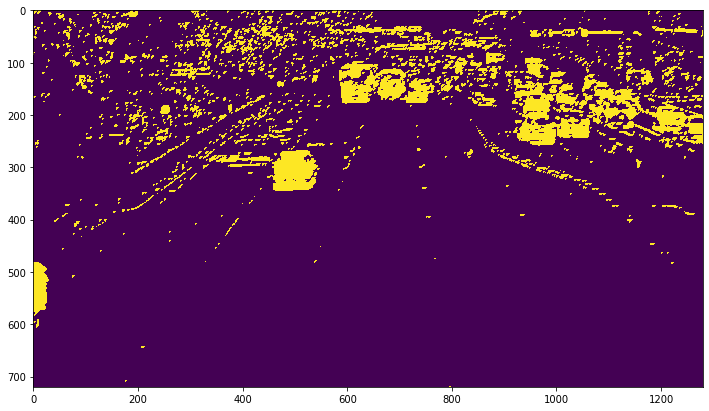

In [4]:

def filter_mask(img):
    '''
        This filters are hand-picked just based on visual tests
    '''

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))

    # Fill any small holes
    closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    # Remove noise
    opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)

    # Dilate to merge adjacent blobs
    dilation = cv2.dilate(opening, kernel, iterations=2)

    return dilation

bg_subtractor = cv2.createBackgroundSubtractorMOG2(
        history=500, detectShadows=True)

# Set up image source
cap = skvideo.io.vreader(VIDEO_SOURCE)

# skipping 500 frames to train bg subtractor
train_bg_subtractor(bg_subtractor, cap, num=500)

frame = next(cap)
fg_mask = bg_subtractor.apply(frame, None, 0.001)
fg_mask[fg_mask < 240] = 0
fg_mask = filter_mask(fg_mask)

plt.figure(figsize=(12,12))
plt.imshow(fg_mask)
plt.show()

## Object detection by contours

For this purpose we will use the standard cv2.findContours method with params:

```
cv2.CV_RETR_EXTERNAL — get only outer contours.
cv2.CV_CHAIN_APPROX_TC89_L1 - use Teh-Chin chain approximation algorithm (faster)
```



In [5]:
def get_centroid(x, y, w, h):
    x1 = int(w / 2)
    y1 = int(h / 2)

    cx = x + x1
    cy = y + y1

    return (cx, cy)


class ContourDetection:
    '''
        Detecting moving objects.

        Purpose of this processor is to subtrac background, get moving objects
        and detect them with a cv2.findContours method, and then filter off-by
        width and height. 

        bg_subtractor - background subtractor isinstance.
        min_contour_width - min bounding rectangle width.
        min_contour_height - min bounding rectangle height.
        save_image - if True will save detected objects mask to file.
        image_dir - where to save images(must exist).        
    '''

    def __init__(self, bg_subtractor, min_contour_width=35, min_contour_height=35, save_image=False, image_dir='images'):
        super(ContourDetection, self).__init__()

        self.bg_subtractor = bg_subtractor
        self.min_contour_width = min_contour_width
        self.min_contour_height = min_contour_height
        self.save_image = save_image
        self.image_dir = image_dir

    def filter_mask(self, img, a=None):
        '''
            This filters are hand-picked just based on visual tests
        '''

        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))

        # Fill any small holes
        closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
        # Remove noise
        opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)

        # Dilate to merge adjacent blobs
        dilation = cv2.dilate(opening, kernel, iterations=2)

        return dilation

    def detect_vehicles(self, fg_mask):

        matches = []

        # finding external contours
        contours, hierarchy = cv2.findContours(
            fg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_L1)

        for (i, contour) in enumerate(contours):
            (x, y, w, h) = cv2.boundingRect(contour)
            # On the exit, we add some filtering by height, width and add centroid.
            contour_valid = (w >= self.min_contour_width) and (
                h >= self.min_contour_height)

            if not contour_valid:
                continue

            centroid = get_centroid(x, y, w, h)

            matches.append(((x, y, w, h), centroid))

        return matches

    def __call__(self, frame):
        frame = frame.copy()

        fg_mask = self.bg_subtractor.apply(frame, None, 0.001)
        # just thresholding values
        fg_mask[fg_mask < 240] = 0
        fg_mask = self.filter_mask(fg_mask, 0)

        return self.detect_vehicles(fg_mask)

cd = ContourDetection(bg_subtractor)

bg_subtractor = cv2.createBackgroundSubtractorMOG2(
        history=500, detectShadows=True)

# Set up image source
cap = skvideo.io.vreader(VIDEO_SOURCE)

# skipping 500 frames to train bg subtractor
train_bg_subtractor(bg_subtractor, cap, num=500)

frame = next(cap)
objects = cd(frame)

print('Getting list of [((x,y,w,h), (xc,yc)), ...]')
print(objects)

Training BG Subtractor...
Getting list of [((x,y,w,h), (xc,yc)), ...]
[((448, 268, 101, 77), (498, 306)), ((997, 139, 73, 57), (1033, 167)), ((701, 129, 67, 49), (734, 153)), ((918, 126, 146, 134), (991, 193)), ((1048, 122, 232, 119), (1164, 181)), ((1133, 109, 55, 35), (1160, 126)), ((584, 97, 156, 81), (662, 137)), ((940, 90, 37, 39), (958, 109)), ((784, 89, 48, 36), (808, 107)), ((654, 42, 126, 40), (717, 62)), ((362, 37, 68, 47), (396, 60)), ((416, 25, 90, 44), (461, 47))]


## Building processing pipeline

You must understand that in ML and CV there is no one magic algorithm that making altogether, even if we imagine that such algorithm exists, we still wouldn’t use it because it would be not effective at scale. For example a few years ago Netflix created competition with the prize 3 million dollars for the best movie recommendation algorithm. And one of the team created such, problem was that it just couldn’t work at scale and thus was useless for the company. But still, Netflix paid 1 million to them :)

So now we will build simple processing pipeline, it not for scale just for convenient but the idea the same.



In [0]:

class PipelineRunner(object):
    '''
        Very simple pipline.

        Just run passed processors in order with passing context from one to 
        another.

        You can also set log level for processors.
    '''

    def __init__(self, pipeline=None, log_level=logging.INFO):
        self.pipeline = pipeline or []
        self.context = {}
        self.log = logging.getLogger(self.__class__.__name__)
        self.log.setLevel(log_level)
        self.log_level = log_level
        self.set_log_level()

    def set_context(self, data):
        self.context = data

    def add(self, processor):
        if not isinstance(processor, PipelineProcessor):
            raise Exception(
                'Processor should be an isinstance of PipelineProcessor.')
        processor.log.setLevel(self.log_level)
        self.pipeline.append(processor)

    def remove(self, name):
        for i, p in enumerate(self.pipeline):
            if p.__class__.__name__ == name:
                del self.pipeline[i]
                return True
        return False

    def set_log_level(self):
        for p in self.pipeline:
            p.log.setLevel(self.log_level)

    def run(self):
        for p in self.pipeline:
            self.context = p(self.context)

        self.log.debug("Frame #%d processed.", self.context['frame_number'])

        return self.context


class PipelineProcessor(object):
    '''
        Base class for processors.
    '''

    def __init__(self):
        self.log = logging.getLogger(self.__class__.__name__)

As input constructor will take a list of processors that will be run in order. Each processor making part of the job. 

We already have Countour Detection class, just need slightly udate it to use context



In [0]:
def save_frame(frame, file_name, flip=True):
    # flip BGR to RGB
    if flip:
        cv2.imwrite(file_name, np.flip(frame, 2))
    else:
        cv2.imwrite(file_name, frame)

class ContourDetection(PipelineProcessor):
    '''
        Detecting moving objects.

        Purpose of this processor is to subtrac background, get moving objects
        and detect them with a cv2.findContours method, and then filter off-by
        width and height. 

        bg_subtractor - background subtractor isinstance.
        min_contour_width - min bounding rectangle width.
        min_contour_height - min bounding rectangle height.
        save_image - if True will save detected objects mask to file.
        image_dir - where to save images(must exist).        
    '''

    def __init__(self, bg_subtractor, min_contour_width=35, min_contour_height=35, save_image=False, image_dir='images'):
        super(ContourDetection, self).__init__()

        self.bg_subtractor = bg_subtractor
        self.min_contour_width = min_contour_width
        self.min_contour_height = min_contour_height
        self.save_image = save_image
        self.image_dir = image_dir

    def filter_mask(self, img, a=None):
        '''
            This filters are hand-picked just based on visual tests
        '''

        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))

        # Fill any small holes
        closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
        # Remove noise
        opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)

        # Dilate to merge adjacent blobs
        dilation = cv2.dilate(opening, kernel, iterations=2)

        return dilation

    def detect_vehicles(self, fg_mask, context):

        matches = []

        # finding external contours
        contours, hierarchy = cv2.findContours(
            fg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_L1)

        for (i, contour) in enumerate(contours):
            (x, y, w, h) = cv2.boundingRect(contour)
            contour_valid = (w >= self.min_contour_width) and (
                h >= self.min_contour_height)

            if not contour_valid:
                continue

            centroid = get_centroid(x, y, w, h)

            matches.append(((x, y, w, h), centroid))

        return matches

    def __call__(self, context):
        frame = context['frame'].copy()
        frame_number = context['frame_number']

        fg_mask = self.bg_subtractor.apply(frame, None, 0.001)
        # just thresholding values
        fg_mask[fg_mask < 240] = 0
        fg_mask = self.filter_mask(fg_mask, frame_number)

        if self.save_image:
            save_frame(fg_mask, self.image_dir +
                             "/mask_%04d.png" % frame_number, flip=False)

        context['objects'] = self.detect_vehicles(fg_mask, context)
        context['fg_mask'] = fg_mask

        return context


Now let’s create a processor that will link detected objects on different frames and will create paths, and also will count vehicles that got to the exit zone.

In [0]:
def distance(x, y, type='euclidian', x_weight=1.0, y_weight=1.0):
    if type == 'euclidian':
        return math.sqrt(float((x[0] - y[0])**2) / x_weight + float((x[1] - y[1])**2) / y_weight)


class VehicleCounter(PipelineProcessor):
    '''
        Counting vehicles that entered in exit zone.

        Purpose of this class based on detected object and local cache create
        objects pathes and count that entered in exit zone defined by exit masks.

        exit_masks - list of the exit masks.
        path_size - max number of points in a path.
        max_dst - max distance between two points.
    '''

    def __init__(self, exit_masks=[], path_size=10, max_dst=30, x_weight=1.0, y_weight=1.0):
        super(VehicleCounter, self).__init__()

        self.exit_masks = exit_masks

        self.vehicle_count = 0
        self.path_size = path_size
        self.pathes = []
        self.max_dst = max_dst
        self.x_weight = x_weight
        self.y_weight = y_weight

    def check_exit(self, point):
        for exit_mask in self.exit_masks:
            try:
                if exit_mask[point[1]][point[0]] == 255:
                    return True
            except:
                return True
        return False

    def __call__(self, context):
        objects = context['objects']
        context['exit_masks'] = self.exit_masks
        context['pathes'] = self.pathes
        context['vehicle_count'] = self.vehicle_count
        if not objects:
            return context

        points = np.array(objects)[:, 0:2]
        points = points.tolist()

        # add new points if pathes is empty
        if not self.pathes:
            for match in points:
                self.pathes.append([match])

        else:
            # link new points with old pathes based on minimum distance between
            # points
            new_pathes = []

            for path in self.pathes:
                _min = 999999
                _match = None
                for p in points:
                    if len(path) == 1:
                        # distance from last point to current
                        d = distance(p[0], path[-1][0])
                    else:
                        # based on 2 prev points predict next point and calculate
                        # distance from predicted next point to current
                        xn = 2 * path[-1][0][0] - path[-2][0][0]
                        yn = 2 * path[-1][0][1] - path[-2][0][1]
                        d = distance(
                            p[0], (xn, yn),
                            x_weight=self.x_weight,
                            y_weight=self.y_weight
                        )

                    if d < _min:
                        _min = d
                        _match = p

                if _match and _min <= self.max_dst:
                    points.remove(_match)
                    path.append(_match)
                    new_pathes.append(path)

                # do not drop path if current frame has no matches
                if _match is None:
                    new_pathes.append(path)

            self.pathes = new_pathes

            # add new pathes
            if len(points):
                for p in points:
                    # do not add points that already should be counted
                    if self.check_exit(p[1]):
                        continue
                    self.pathes.append([p])

        # save only last N points in path
        for i, _ in enumerate(self.pathes):
            self.pathes[i] = self.pathes[i][self.path_size * -1:]

        # count vehicles and drop counted pathes:
        new_pathes = []
        for i, path in enumerate(self.pathes):
            d = path[-2:]

            if (
                # need at list two points to count
                len(d) >= 2 and
                # prev point not in exit zone
                not self.check_exit(d[0][1]) and
                # current point in exit zone
                self.check_exit(d[1][1]) and
                # path len is bigger then min
                self.path_size <= len(path)
            ):
                self.vehicle_count += 1
            else:
                # prevent linking with path that already in exit zone
                add = True
                for p in path:
                    if self.check_exit(p[1]):
                        add = False
                        break
                if add:
                    new_pathes.append(path)

        self.pathes = new_pathes

        context['pathes'] = self.pathes
        context['objects'] = objects
        context['vehicle_count'] = self.vehicle_count

        self.log.debug('#VEHICLES FOUND: %s' % self.vehicle_count)

        return context



This class a bit complicated so let’s walk through it by parts.

<img src="https://miro.medium.com/max/1280/1*yTW0iqr8QK24Fkb6JJHhLw.png" />

This green mask on the image is exit zone, is where we counting our vehicles. For example, we will count only paths that have length more than 3 points(to remove some noise) and the 4th in the green zone.
We use masks cause it’s many operation effective and simpler than using vector algorithms. 

Just use “binary and” operation to check that point in the area, and that’s all. And here is how we set it:

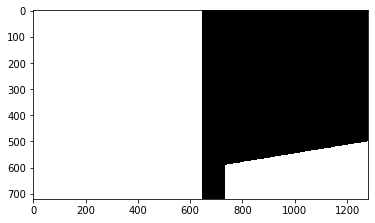

In [9]:
EXIT_PTS = np.array([
    [[732, 720], [732, 590], [1280, 500], [1280, 720]],
    [[0, 720], [645, 720], [645, 0], [0, 0]]
])
SHAPE = (720,1280)
base = np.zeros(SHAPE + (3,), dtype='uint8')
exit_mask = cv2.fillPoly(base, EXIT_PTS, (255, 255, 255))[:, :, 0]

plt.imshow(base)
plt.show()

Now let’s link points in paths at [line 55](#scrollTo=lh3dhyf9iaKF&line=55&uniqifier=1)

On first frame. we just add all points as new paths.

Next if len(path) == 1, for each path in the cache we are trying to find the point(centroid) from newly detected objects which will have the smallest Euclidean distance to the last point of the path.

If len(path) > 1, then with the last two points in the path we are predicting new point on the same line, and finding min distance between it and the current point.

The point with minimal distance added to the end of the current path and removed from the list.

If some points left after this we add them as new paths.

And also we limit the number of points in the path at [line 101](#scrollTo=lh3dhyf9iaKF&line=101&uniqifier=1/)

Now we will try to count vehicles that entering in the exit zone. To do this we just take 2 last points in the path and checking that last of them in exit zone, and previous not, and also checking that len(path) should be bigger than limit.
The part after else is preventing of back-linking new points to the points in exit zone.

And the last two processor is CSV writer to create report CSV file, and visualization for debugging and nice pictures/videos.

In [0]:
class CsvWriter(PipelineProcessor):

    def __init__(self, path, name, start_time=0, fps=15):
        super(CsvWriter, self).__init__()

        self.fp = open(os.path.join(path, name), 'w')
        self.writer = csv.DictWriter(self.fp, fieldnames=['time', 'vehicles'])
        self.writer.writeheader()
        self.start_time = start_time
        self.fps = fps
        self.path = path
        self.name = name
        self.prev = None

    def __call__(self, context):
        frame_number = context['frame_number']
        count = _count = context['vehicle_count']

        if self.prev:
            _count = count - self.prev

        time = ((self.start_time + int(frame_number / self.fps)) * 100 
                + int(100.0 / self.fps) * (frame_number % self.fps))
        self.writer.writerow({'time': time, 'vehicles': _count})
        self.prev = count

        return context

BOUNDING_BOX_COLOUR = (255, 192, 0)
CENTROID_COLOUR = (255, 192, 0)
CAR_COLOURS = [(255, 192, 0)]
EXIT_COLOR = (66, 183, 42)

class Visualizer(PipelineProcessor):

    def __init__(self, save_image=True, image_dir='images'):
        super(Visualizer, self).__init__()

        self.save_image = save_image
        self.image_dir = image_dir

    def check_exit(self, point, exit_masks=[]):
        for exit_mask in exit_masks:
            if exit_mask[point[1]][point[0]] == 255:
                return True
        return False

    def draw_pathes(self, img, pathes):
        if not img.any():
            return

        for i, path in enumerate(pathes):
            path = np.array(path)[:, 1].tolist()
            for point in path:
                cv2.circle(img, point, 2, CAR_COLOURS[0], -1)
                cv2.polylines(img, [np.int32(path)], False, CAR_COLOURS[0], 1)

        return img

    def draw_boxes(self, img, pathes, exit_masks=[]):
        for (i, match) in enumerate(pathes):

            contour, centroid = match[-1][:2]
            if self.check_exit(centroid, exit_masks):
                continue

            x, y, w, h = contour

            cv2.rectangle(img, (x, y), (x + w - 1, y + h - 1),
                          BOUNDING_BOX_COLOUR, 1)
            cv2.circle(img, centroid, 2, CENTROID_COLOUR, -1)

        return img

    def draw_ui(self, img, vehicle_count, exit_masks=[]):

        # this just add green mask with opacity to the image
        for exit_mask in exit_masks:
            _img = np.zeros(img.shape, img.dtype)
            _img[:, :] = EXIT_COLOR
            mask = cv2.bitwise_and(_img, _img, mask=exit_mask)
            cv2.addWeighted(mask, 1, img, 1, 0, img)

        # drawing top block with counts
        cv2.rectangle(img, (0, 0), (img.shape[1], 50), (0, 0, 0), cv2.FILLED)
        cv2.putText(img, ("Vehicles passed: {total} ".format(total=vehicle_count)), (30, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 1)
        return img

    def __call__(self, context):
        frame = context['frame'].copy()
        frame = np.ascontiguousarray(np.flip(frame, 2))
        frame_number = context['frame_number']
        pathes = context['pathes']
        exit_masks = context['exit_masks']
        vehicle_count = context['vehicle_count']

        frame = self.draw_ui(frame, vehicle_count, exit_masks)
        frame = self.draw_pathes(frame, pathes)
        frame = self.draw_boxes(frame, pathes, exit_masks)
        if self.save_image:
            save_frame(frame, self.image_dir +
                            "/processed_%04d.png" % frame_number)

        context['frame'] = frame
        return context

CSV writer is saving data by time, cause we need it for further analytics. So i use this formula to add additional frame timing to the unixtimestamp:

```
time = ((self.start_time + int(frame_number / self.fps)) * 100 
                + int(100.0 / self.fps) * (frame_number % self.fps))
```

```
so with start time=1 000 000 000 and fps=10 i will get results like this
frame 1 = 1 000 000 000 010
frame 1 = 1 000 000 000 020
…
```



Then after you get full csv report you can aggregate this data as you want.

## Conclusion
So as you see it was not so hard as many people think.

But if you run the script you will see that this solution is not ideal, and having a problem with foreground objects overlapping, also it doesn’t have vehicles classification by types(that you will definitely need for real analytics). But still, with good camera position(above the road), it gives pretty good accuracy. And that tells us that even small & simple algorithms used in a right way can give good results.

**So what we can do to fix current issues?**

One way is to try adding some additional filtration trying to separate objects for better detection. Another is to use more complex algorithms like deep convolution networks, which u can study on our course http://learnml.today

In [0]:
# build runner
def main():
    log = logging.getLogger("main")

    # creating exit mask from points, where we will be counting our vehicles
    base = np.zeros(SHAPE + (3,), dtype='uint8')
    exit_mask = cv2.fillPoly(base, EXIT_PTS, (255, 255, 255))[:, :, 0]

    # there is also bgslibrary, that seems to give better BG substruction, but
    # not tested it yet
    bg_subtractor = cv2.createBackgroundSubtractorMOG2(
        history=500, detectShadows=True)

    # processing pipline for programming conviniance
    pipeline = PipelineRunner(pipeline=[
        ContourDetection(bg_subtractor=bg_subtractor,
                         save_image=True, image_dir=IMAGE_DIR),
        # we use y_weight == 2.0 because traffic are moving vertically on video
        # use x_weight == 2.0 for horizontal.
        VehicleCounter(exit_masks=[exit_mask], y_weight=2.0),
        Visualizer(image_dir=IMAGE_DIR,save_image=False),
        CsvWriter(path='./', name='report.csv')
    ], log_level=logging.INFO)

    # Set up image source
    cap = skvideo.io.vreader(VIDEO_SOURCE)

    # skipping 500 frames to train bg subtractor
    train_bg_subtractor(bg_subtractor, cap, num=500)

    fourcc = cv2.VideoWriter_fourcc(*"MP4V")
    writer = cv2.VideoWriter(VIDEO_OUT, fourcc, 25, (SHAPE[1], SHAPE[0]), True)

    frame_number = -1
    for frame in cap:
        if not frame.any():
            log.error("Frame capture failed, stopping...")
            break

        frame_number += 1
        log.info("Frame #%s" % frame_number)

        pipeline.set_context({
            'frame': frame,
            'frame_number': frame_number,
        })
        ctx = pipeline.run()
        writer.write(ctx['frame'])

        if frame_number > PARSE_FRAMES:
            break
    writer.release()

In [14]:
# Parameters
# ============================================================================
IMAGE_DIR = "./out"
VIDEO_SOURCE = "2.1M Full HD 1080P CCTV Footage.mp4"
VIDEO_OUT = "roadrsed.mp4"
PARSE_FRAMES = 15*25
SHAPE = (720, 1280)  # HxW
EXIT_PTS = np.array([
    [[0, 720], [1280, 720], [1280, 360], [0, 360]]])
# ============================================================================

log = init_logging()
main()

Training BG Subtractor...
2020-01-20 21:08:09.515 INFO     [main] Frame #0
2020-01-20 21:08:09.598 INFO     [main] Frame #1
2020-01-20 21:08:09.672 INFO     [main] Frame #2
2020-01-20 21:08:09.750 INFO     [main] Frame #3
2020-01-20 21:08:09.822 INFO     [main] Frame #4
2020-01-20 21:08:09.895 INFO     [main] Frame #5
2020-01-20 21:08:09.967 INFO     [main] Frame #6
2020-01-20 21:08:10.037 INFO     [main] Frame #7
2020-01-20 21:08:10.113 INFO     [main] Frame #8
2020-01-20 21:08:10.190 INFO     [main] Frame #9
2020-01-20 21:08:10.268 INFO     [main] Frame #10
2020-01-20 21:08:10.350 INFO     [main] Frame #11
2020-01-20 21:08:10.424 INFO     [main] Frame #12
2020-01-20 21:08:10.496 INFO     [main] Frame #13
2020-01-20 21:08:10.573 INFO     [main] Frame #14
2020-01-20 21:08:10.651 INFO     [main] Frame #15
2020-01-20 21:08:10.723 INFO     [main] Frame #16
2020-01-20 21:08:10.802 INFO     [main] Frame #17
2020-01-20 21:08:10.876 INFO     [main] Frame #18
2020-01-20 21:08:10.953 INFO     [

In [0]:
from google.colab import files
files.download("roadrsed.mp4")

# [Become an Object Detection Expert with our practical course](http://learnml.today)